### HR Analytics Model Comparison

#### Set source path to import code

In [1]:
%pwd

'C:\\Users\\t0272m1\\Projects\\HR Analytics\\notebooks'

In [2]:
source_path = 'E:\HR-Analytics\source'
source_path

'E:\\HR-Analytics\\source'

In [3]:
import os
os.chdir(source_path)
%pwd

'E:\\HR-Analytics\\source'

In [4]:
ls

 Volume in drive E is DATA
 Volume Serial Number is AEFF-63BE

 Directory of E:\HR-Analytics\source

09/26/2019  01:44 PM    <DIR>          .
09/26/2019  01:44 PM    <DIR>          ..
05/02/2019  11:01 AM                 2 __init__.py
09/30/2019  03:00 PM    <DIR>          __pycache__
09/30/2019  09:14 AM           210,420 abs_weather_tbl.csv
07/15/2019  02:57 PM            16,924 base_table.py
06/13/2019  11:21 AM            26,727 calendrical.py
09/26/2019  01:10 PM             1,881 config_bvp.yml
09/20/2019  09:25 AM             4,201 config_jnap.yml
09/20/2019  09:25 AM            13,481 config_shap.yml
09/20/2019  09:25 AM             6,587 config_tac.yml
09/24/2019  01:22 PM             1,942 config_wap.yml
09/20/2019  09:25 AM             6,360 config_wtap.yml
09/30/2019  10:29 AM           995,490 darksky_weather.log
09/18/2019  11:19 AM             6,314 database.py
09/26/2019  01:10 PM            15,163 main.py
09/25/2019  01:53 PM            49,153 model.py
08/27/2019  10:1

#### Imports

In [5]:
import calendar
import datetime
import itertools
import jaydebeapi as jdb
import json
import math
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import random
import requests
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import urllib.request

In [6]:
# Internal Python Packages
from main import get_pipeline_config
from main import get_plant_config

#### Utility Functions

In [7]:
def get_metrics(df, actual='actual', predicted='predicted'):
    actual = df[actual]
    predicted = df[predicted]
    metrics = {}
    metrics['MAE'] = round(mean_absolute_error(actual, predicted), 3)
    metrics['MSE'] = round(mean_squared_error(actual, predicted), 3)
    metrics['R2'] = round(r2_score(actual, predicted), 3)
    diffs = actual - predicted
    df_q = pd.DataFrame(diffs, columns=['diff'])
    metrics['Q1'] = round(df_q['diff'].quantile(0.6826), 3)
    metrics['Q2'] = round(df_q['diff'].quantile(0.9544), 3)
    return metrics, actual, predicted, diffs

#### Get specifications

In [8]:
pipeline_specs = get_pipeline_config(source_path)
pipeline_specs

{'datalake': {'schema': 'lab_datasci',
  'host': 'shbdmdwp001.servers.chrysler.com',
  'port': 5432,
  'user': 'datasci',
  'password': 'datasci_01',
  'database': 'odshawq'},
 'jdbc': {'driver': 'com.ibm.db2.jcc.DB2Driver',
  'server': 'jdbc:db2://SRVR1874.dbms.chrysler.com:18740/AUCERPTP',
  'user': 'datasci',
  'password': 'datasci_01',
  'jar_file': 'c:/installed/sqllib/java/db2jcc4.jar'},
 'holidays': {'calendar_us': ['2016-01-01',
   '2016-01-18',
   '2016-03-25',
   '2016-03-28',
   '2016-05-30',
   '2016-07-04',
   '2016-09-05',
   '2016-11-08',
   '2016-11-11',
   '2016-11-24',
   '2016-11-25',
   '2016-12-26',
   '2016-12-27',
   '2016-12-28',
   '2016-12-29',
   '2016-12-30',
   '2017-01-02',
   '2017-01-22',
   '2017-04-14',
   '2017-04-17',
   '2017-05-29',
   '2017-07-04',
   '2017-09-04',
   '2017-11-10',
   '2017-11-22',
   '2017-11-23',
   '2017-12-25',
   '2017-12-26',
   '2017-12-29',
   '2017-12-30',
   '2017-12-31',
   '2018-01-01',
   '2018-01-15',
   '2018-03-30'

In [9]:
plant_id = 'jnap'
plant_id

'jnap'

In [10]:
pipeline_specs['plant_id'] = plant_id
pipeline_specs['project_directory'] = source_path
pipeline_specs

{'datalake': {'schema': 'lab_datasci',
  'host': 'shbdmdwp001.servers.chrysler.com',
  'port': 5432,
  'user': 'datasci',
  'password': 'datasci_01',
  'database': 'odshawq'},
 'jdbc': {'driver': 'com.ibm.db2.jcc.DB2Driver',
  'server': 'jdbc:db2://SRVR1874.dbms.chrysler.com:18740/AUCERPTP',
  'user': 'datasci',
  'password': 'datasci_01',
  'jar_file': 'c:/installed/sqllib/java/db2jcc4.jar'},
 'holidays': {'calendar_us': ['2016-01-01',
   '2016-01-18',
   '2016-03-25',
   '2016-03-28',
   '2016-05-30',
   '2016-07-04',
   '2016-09-05',
   '2016-11-08',
   '2016-11-11',
   '2016-11-24',
   '2016-11-25',
   '2016-12-26',
   '2016-12-27',
   '2016-12-28',
   '2016-12-29',
   '2016-12-30',
   '2017-01-02',
   '2017-01-22',
   '2017-04-14',
   '2017-04-17',
   '2017-05-29',
   '2017-07-04',
   '2017-09-04',
   '2017-11-10',
   '2017-11-22',
   '2017-11-23',
   '2017-12-25',
   '2017-12-26',
   '2017-12-29',
   '2017-12-30',
   '2017-12-31',
   '2018-01-01',
   '2018-01-15',
   '2018-03-30'

In [11]:
plant_specs = get_plant_config(pipeline_specs)
plant_specs

{'plant': {'code': 4012,
  'latitude': 42.375292,
  'longitude': -82.966222,
  'market_id': 7,
  'shift_days': 4,
  'shift_hours': 10,
  'absence_codes': ['BERC',
   'BERE',
   'BERU',
   'BERX',
   'CARE',
   'CARU',
   'FMLA',
   'FMLD',
   'FMLU',
   'HOMD',
   'ILFE',
   'ILFU',
   'IPBE',
   'IPME',
   'IPNU',
   'IPSE',
   'JURE',
   'MISE',
   'MISU',
   'PERU',
   'PPAA',
   'PPAU',
   'TRAG',
   'WTRU'],
  'exclude_dates': [['2018-08-25', '2018-08-31'],
   ['2019-01-02', '2019-01-05'],
   ['2020-08-10', '2020-08-14']]},
 'base_table': {'start_date': datetime.date(2017, 1, 1),
  'end_date': None,
  'create_table': True,
  'write_table': True,
  'use_table_date': datetime.date(2019, 9, 8)},
 'model': {'models': ['sarimax'],
  'target': 'absences_unplanned',
  'npreds': 4,
  'p_arima': 1,
  'd_arima': 0,
  'q_arima': 0,
  'features': ['actual_hours',
   'lost_hours',
   'absences_unplanned_rolling_median_12',
   'absences_unplanned_rolling_median_20',
   'quarter',
   'month',
  

In [12]:
departments = plant_specs['model']['departments']
departments

{'Material': '3300',
 'Body Shop': '9110',
 'Paint Shop': '9130',
 'Trim': '9150',
 'Chassis': '9170',
 'Final': '9173',
 'Quality 1': '9190',
 'Quality 2': '9193'}

In [13]:
crews = plant_specs['model']['crews']
crews

['A', 'B', 'C']

In [14]:
pline_map = plant_specs['model']['production_lines']
pline_map

{'Material': ['Material', ['11', '12', '24', '41', '42', '43', '44', '45']],
 'Body Shop': ['Body Shop', []],
 'Paint Shop': ['Paint Shop', []],
 'Trim 1': ['Trim',
  ['01',
   '02',
   '03',
   '04',
   '05',
   '06',
   '07',
   '08',
   '09',
   '10',
   '11',
   '12',
   '22']],
 'Trim 2': ['Trim', ['13', '14', '15', '16', '17', '18', '19', '20', '21']],
 'Door Line': ['Trim', ['35', '36', '37', '38', '39', '40', '41']],
 'Engine Line': ['Chassis', ['01', '02', '03', '04', '05', '06', '07']],
 'Chassis 1 & 2': ['Chassis',
  ['08', '09', '10', '11', '12', '13', '14', '15', '16', '17']],
 'Sunroof Deck': ['Chassis', ['18', '19', '20', '21', '22']],
 'Chassis 3': ['Chassis',
  ['23', '24', '25', '26', '27', '28', '29', '30', '31']],
 'Chassis 4': ['Chassis', ['32', '33', '34', '35', '36', '37', '38']],
 'Final 1': ['Final', ['01', '02', '03', '04', '05', '06', '07', '08']],
 'Final 2': ['Final', ['09', '10', '11', '12', '13', '14']],
 'Rolls': ['Final', ['15', '16', '17']],
 'Quality 

In [15]:
plines = list(pline_map.keys())
plines

['Material',
 'Body Shop',
 'Paint Shop',
 'Trim 1',
 'Trim 2',
 'Door Line',
 'Engine Line',
 'Chassis 1 & 2',
 'Sunroof Deck',
 'Chassis 3',
 'Chassis 4',
 'Final 1',
 'Final 2',
 'Rolls',
 'Quality 1',
 'Quality 2']

#### Data Path

In [24]:
data_path = 'E:\HR-Analytics\data'
data_path

'E:\\HR-Analytics\\data'

In [25]:
# input_file is the plant table
table_date = '20191006'
table_name = '_'.join(['abs', plant_id, 'plant', 'crew', 'production_line', table_date, 'tbl'])
file_name = '.'.join([table_name, 'csv'])
file_path = '/'.join([data_path, file_name])
dfp = pd.read_csv(file_path)

In [26]:
dfp.shape

(12878, 87)

In [27]:
dfp.columns

Index(['crew', 'model_feature1', 'model_feature2', 'model_feature3',
       'model_feature4', 'model_feature5', 'predicted', 'predicted_high',
       'predicted_low', 'production_line', 'workdate', 'group_total_cid',
       'lost_hours', 'actual_hours', 'paa_hours', 'absences_unplanned',
       'absences_late', 'absences_noshow', 'absences_any', 'mean_absence_pct',
       'mean_experience', 'absences_planned', 'home_canvasses',
       'absences_fmla', 'peia_count', 'tpt_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'group_total', 'tpt_unplanned',
       'tpt_extra', 'absences_unplanned_rolling_sum_5',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_sum_12',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_sum_20',
       'absences_unplanned_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_

In [28]:
dfp.sample(20)

,crew,model_feature1,model_feature2,model_feature3,model_feature4,model_feature5,predicted,predicted_high,predicted_low,production_line,...,feature3,feature4,feature5,event_name,event_date,event_time,genre,au_event_mean,au_event_pct,feature_event
5757,C,absences_any,home_canvasses,group_total,paa_hours,next_day_delta,10.0,13,7,Engine Line,...,November: -7%,3rd Monday: 18%,3 days before Thanksgiving: 10%,NaN,0,0,0,0.0,0,NaN
4720,C,kp_residual_5,next_day_delta,absences_unplanned_rolling_sum_20,absences_unplanned_rolling_median_20,lost_hours_rolling_mean_20,6.0,8,4,Chassis 3,...,September: -11%,4th Saturday: -11%,19 days after Labor Day: -43%,NaN,0,0,0,0.0,0,NaN
5881,A,streak_3,next_day_delta,streak_2,absences_unplanned_rolling_median_20,absences_fmla,1.0,1,1,Rolls,...,November: -16%,4th Wednesday: -36%,6 days after Thanksgiving: -44%,NaN,0,0,0,0.0,0,NaN
9563,A,week,day_of_year,day_of_week,month,day,4.0,5,3,Sunroof Deck,...,June: 10%,2nd Wednesday: -16%,4 days before Father's Day: -100%,NaN,0,0,0,0.0,0,NaN
3757,B,day_of_week,week,next_day_delta,day_of_year,month,3.0,4,2,Final 2,...,July: 8%,4th Wednesday: 8%,21 days after Independence Day: 9%,NaN,0,0,0,0.0,0,NaN
2151,C,day,month,kp_residual_20,year,actual_hours_rolling_mean_20,5.0,6,4,Final 2,...,April: -3%,4th Saturday: -26%,7 days before Cinco de Mayo: -63%,NaN,0,0,0,0.0,0,NaN
3478,A,absences_unplanned_rolling_median_5,absences_unplanned_rolling_sum_5,absences_unplanned_rolling_sum_12,absences_unplanned_rolling_sum_20,next_day_delta,6.0,8,4,Chassis 4,...,July: 13%,2nd Wednesday: -5%,7 days after Independence Day: 52%,NaN,0,0,0,0.0,0,NaN
4174,B,absences_late,cluster,absences_planned,absences_any,tpt_unplanned,7.0,9,5,Final 1,...,August: 1%,3rd Thursday: -15%,18 days before Labor Day: -22%,NaN,0,0,0,0.0,0,NaN
4362,A,peia_count,absences_unplanned_rolling_median_5,absences_unplanned_rolling_sum_5,cluster,streak_3,3.0,4,2,Final 2,...,September: 4%,1st Tuesday: -6%,1 days after Labor Day: 18%,NaN,0,0,0,0.0,0,NaN
9996,B,lost_hours,actual_hours,absences_unplanned_rolling_median_12,day_of_week,day,11.0,14,8,Trim 1,...,June: 27%,4th Thursday: -28%,7 days before Independence Day: -16%,NaN,0,0,0,0.0,0,NaN


#### Baseline Model Metrics

In [29]:
metric_start_date = '2019-09-22'
metric_end_date = '2019-09-28'

In [30]:
dfp_metric = dfp[(dfp['workdate'] >= metric_start_date) & (dfp['workdate'] <= metric_end_date)]
dfp_metric['workdate'].min(), dfp_metric['workdate'].max()

('2019-09-23', '2019-09-28')

In [31]:
dfp_metric = dfp_metric[['crew', 'production_line', 'workdate', 'actual', 'predicted']]
dfp_metric = dfp_metric[dfp_metric['predicted'] > 0]
dfp_metric.sample(50)

,crew,production_line,workdate,actual,predicted
12381,A,Trim 2,2019-09-25,3.0,7.0
12450,C,Door Line,2019-09-27,7.0,7.0
12408,A,Quality 1,2019-09-26,1.0,3.0
12361,C,Quality 2,2019-09-24,6.0,6.0
12373,A,Final 2,2019-09-25,3.0,4.0
12343,A,Paint Shop,2019-09-24,10.0,8.0
12314,A,Rolls,2019-09-23,3.0,2.0
12403,A,Engine Line,2019-09-26,7.0,6.0
12429,B,Trim 2,2019-09-26,6.0,5.0
12428,B,Trim 1,2019-09-26,9.0,11.0


In [32]:
metrics_champ, actual, predicted, diffs = get_metrics(dfp_metric)
metrics_champ

{'MAE': 1.875, 'MSE': 5.542, 'R2': 0.571, 'Q1': 1.0, 'Q2': 4.0}

In [33]:
sample_line = False
if sample_line:
    test_crew = 'C'
    test_pline = 'Trim 1'
    dfp_test = dfp_metric.query('crew == @test_crew').query('production_line == @test_pline')
    metrics_champ, actual, predicted, diffs = get_metrics(dfp_test)
    print(metrics_champ)

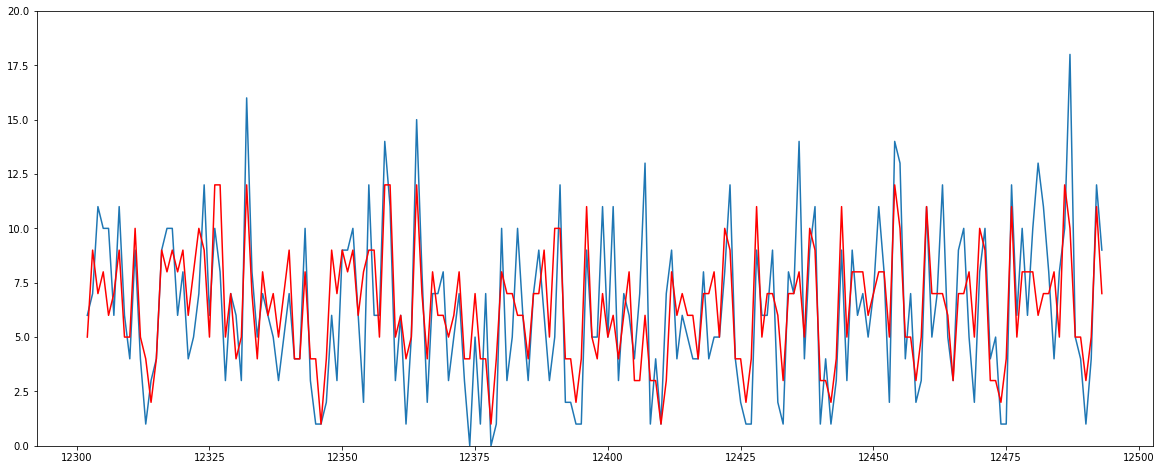

In [35]:
# actual vs. predicted plot
plt.figure(figsize=(20, 8))
plt.plot(actual)
plt.plot(predicted, color='red')
plt.ylim(0, 20)
plt.show()

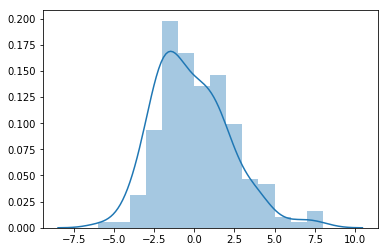

In [36]:
sns.distplot(diffs)

#### Challenger Model Metrics

In [37]:
# predictions file
file_name = '.'.join(['jnap_peak_predictions_crew_production_line_20190922', 'csv'])
file_path = '/'.join([data_path, file_name])
dfc = pd.read_csv(file_path)

In [38]:
dfc.shape

(192, 6)

In [39]:
dfc.columns

Index(['workdate', 'crew', 'production_line', 'predicted', 'predicted_high',
       'predicted_low'],
      dtype='object')

In [40]:
join_cols = ['workdate', 'crew', 'production_line']
join_cols

['workdate', 'crew', 'production_line']

In [41]:
dfc_metric = pd.merge(dfp_metric, dfc,
                      left_on=join_cols,
                      right_on=join_cols,
                      how='left')

In [42]:
dfc_metric.columns

Index(['crew', 'production_line', 'workdate', 'actual', 'predicted_x',
       'predicted_y', 'predicted_high', 'predicted_low'],
      dtype='object')

In [43]:
metrics_challenger, actual, predicted, diffs = get_metrics(dfc_metric, predicted='predicted_y')
metrics_challenger

{'MAE': 2.021, 'MSE': 6.135, 'R2': 0.525, 'Q1': 0.0, 'Q2': 3.29}

#### Example: Challenger Model Metrics with AlphaPy

In [ ]:
# Read in model table
table_name = '_'.join(['abs', plant_id, 'model_seq', table_date, 'tbl'])
file_name = '.'.join([table_name, 'csv'])
file_path = '/'.join([data_path, file_name])
dfm = pd.read_csv(file_path)

In [ ]:
dfm.columns

In [ ]:
target = 'absences_unplanned'
y = dfm[target]
X = dfm.drop(columns=[target])
print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
def save_train_test(home_directory, target, X_train, y_train, X_test, y_test):
    train_file = home_directory + 'train.csv'
    test_file = home_directory + 'test.csv'
    df_train = X_train.copy(deep=True)
    df_train[target] = y_train
    df_train.to_csv(train_file, index=False)
    df_test = X_test.copy(deep=True)
    df_test[target] = y_test
    df_test.to_csv(test_file, index=False)

In [ ]:
alphapy_input_path = 'C:/Users/t0272m1/Projects/HR Analytics/input/'
save_train_test(alphapy_path, target, X_train, y_train, X_test, y_test)

In [ ]:
# Read in challenger metrics as generated by AlphaPy
alphapy_output_path = 'C:/Users/t0272m1/Projects/HR Analytics/output/'
file_name = 'rankings_20190627.csv'
file_path = '/'.join([alphapy_output_path, file_name])
dfc = pd.read_csv(file_path)

In [ ]:
dfc.columns

In [ ]:
dfc['workdate'].min(), dfc['workdate'].max()

#### Comparison Table

In [44]:
df_both = pd.DataFrame.from_dict([metrics_champ, metrics_challenger])
df_both['Model'] = "Champion"
df_both['Model'].iloc[1] = "Challenger"
cols = df_both.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_both = df_both[cols]
print("Model Comparison for period %s to %s" % (metric_start_date, metric_end_date))
df_both

Model Comparison for period 2019-09-22 to 2019-09-28


E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Model,MAE,MSE,Q1,Q2,R2
0,Champion,1.875,5.542,1.0,4.00,0.571
1,Challenger,2.021,6.135,0.0,3.29,0.525


In [46]:
metrics_file = '_'.join(['model_metrics_20190922.csv'])
metrics_path = '/'.join([data_path, metrics_file])
df_both.to_csv(metrics_path, index=False)

### End of Notebook